<h1><center>Detecting Changepoints During Covid-19 Using KATS</center></h1>
<center><b>Authors:</b> Dhruv Arora, Priyanka Bijlani, Sharmeelee Bijlani, Divya Pandey, Lakshmi Venkatasubramanian</center>
<center><b>Project Sponsor:</b> Sourav Chatterjee</center>

# Table of contents
1. [Introduction](#introduction) <br>
2. [Background](#background) <br>
3. [Problem Statement](#problem) <br>
4. [Part 1: Algorithm Evaluation with TCPD Study](#part1) <br>
    a. [Evaluating CUSUMDetector](#part1a) <br>
    b. [Evaluating RobustStatDetector](#part1b) <br>
    c. [Evaluating BOCPDetector](#part1c) <br>
5. [Part 2: Applied Research on Google Mobility Data](#part2) <br>
    a. [Application of CUSUMDetector](#part2a) <br>
    b. [Application of RSDDetector](#part2b) <br>
    c. [Application of BOCPDDetector](#part2c) <br>
6. [Part 3: The Covid-19 Story](#part3) <br>
    a. [Covid-19 in the United States](#part3a) <br>
    b. [Covid-19 in Washington State](#part3b) <br>
    c. [Covid-19 in King County](#part3c) <br>
7. [Conclusion](#conclusion)


## Introduction <a name="introduction"></a>
Meta's Infrastructure Data Science team has released a time-series package called [KATS](https://facebookresearch.github.io/Kats/) to analyze time-series datasets. The KATS package implements multiple changepoint detection algorithms and tries to identify points in a time-series which show a sudden or abrupt change. A changepoint is defined as a ‘persistent change’ in the time series rather than an anomaly or an outlier in the time series data. The goal of this project is to conduct research on time series data and apply the KATS package to multiple datasets in various contexts to assess and evaluate the performance of the time-series algorithms. 

## Background <a name="background"></a>
Changepoint detection has a number of various applications. It is used, for example, in the fields of medicine, aerospace, finance, business, meteorology, and entertainment. Usually, change points are described in terms of changes between segments. To put it simply, a change point divides a time series into multiple segments where each segment has its own statistical characteristics (e.g., mean, variance, etc.). Thus, the change point is located where the underlying characteristics change abruptly. 

A common way to conduct changepoint detection is a sliding window through the signal. The main idea is to walk through the signal with a window of fixed size. For each step, a function computes a chance of having a changepoint in the current window. This function is usually called the cost function. Thus, for each point in the signal, we obtain a cost value indicating whether there is a change at that point or not. Usually, the costs are “low” as long as there is no change in the window and “high” if there is a change in the window. For example, if the costs exceed a predefined threshold, the point is marked as a changepoint, or the points with the highest costs can be marked as changepoints.


The theory of changepoint detection is well established in the literature; several methods have been implemented in standard packages. The question of how to choose the right one is crucial and depends on many factors. As there are many approaches and methods, we present three important factors to make a reasonable decision. First, you need to know your signal and which type of change you have. Second, the runtime plays an important role. Depending on the application, sensors may deliver hundreds of points in one second.  The window-based methods have a runtime of O(T), where T denotes the length of the signal. That is the reason why most of these types of algorithms can be used in online applications. Third, some applications require accurate results. There are other approaches that need a longer runtime but deliver more precise changepoints. Famous methods are, for example, the binary segmentation or bottom-up approaches, which take O(T log(T)) time, but they are still approximations. We will be reviewing the KATS package on multiple parameters mentioned above that would characterize the performance of the package.


## Problem Statement <a name="problem"></a>
As part of this project, we have evaluated the performance of the algorithms in the KATS package based on their ability to accurately detect changepoints. The data we will utilize for performance validation is datasets used in the [Turing Change Point Dataset Benchmark Study](https://github.com/alan-turing-institute/TCPD) and the [Google Mobility Dataset](https://www.google.com/covid19/mobility/) with true labels in the time-series as known by public knowledge. The goal is to derive true stories about the events during Covid-19 based on the retrospectively detected changepoints. This notebook assesses the strengths and shortcomings of the various algorithms implemented in the KATS package and also strives to provide recommendations to improve the algorithms from the applied research conducted as a part of this project.

This notebook contains the following sections:
1. Evaluating changepoint detection algorithms using TCPD benchmark study
2. Applying changepoint algorithms to the Google Mobility data
3. Telling the Covid-19 story through changepoints

## Part 1: Algorithm Evaluation with TCPD Study <a name="part1"></a>
There are two main challenges with changepoint detection problems. The first challenge is using the algorithms to identify changepoints in the dataset since the true label is unknown. This makes it hard to do model evaluation and cross-algorithm performance comparison. The second challenge is to identify the optimal number of changepoints by tuning hyperparameters. 
The Turing Changepoint Datasets benchmark was designed to overcome these exact challenges. The study provides a collection of over 30 datasets with annotated changepoints which can be taken as true changepoints and evaluated against detected changepoints to calculate metrics such as precision and recall for changepoint detection algorithms. The true changepoints were crowdsourced through the [AnnotateChange](https://github.com/alan-turing-institute/annotatechange) tool under the guidance to segment a time-series by points of abrupt change. For the purpose of our assessment, we have interpreted any repeated annotation for a dataset to be a true changepoint. 

### Methodology
In this section, we evaluated each changepoint detection algorithm from the KATS package using the datasets from the Turing study. The code snippets below provide an analysis of an algorithm and it's parameters optimized to find the changepoints closest to the true changepoints and with highest confidence. The purpose of this excercise is to assess the advantages and shortcomings of each algorithm in the KATS package. These insights will be used to determine which algorithm is best suited for Google Mobility data for detecting changepoints during Covid. 

To run any of the code below, make sure to download the [Turing Study Github repository](https://github.com/alan-turing-institute/TCPD) to a chosen directory and save this notebook in the same directory. 

### 1a. Evaluating CUSUMDetector <a name="part1a"></a>
CUSUM is a method to detect an up/down shift of means in a time series. The algorithm is based on likelihood ratio cusum and is used to detect mean changes in Normal Distribution.The typical behavior of the log-likelihood ratio corresponding to a change in the mean of a Gaussian sequence with constant variance is negative drift before and positive drift after the change. So, the change lies in between the value of the log-likelihood ratio and its current minimum value.

The kats package implementation has two main steps:

1. **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point. The next changepoint is the location where the previous CUSUM time series is maximized (or minimized). This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.
2. **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1. The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  If we want to see all the changepoints, we can use the `return_all_changepoints` parameter in `CUSUMDetector` and set it to `True`.

**Underlying assumptions**:

* We assume there is at most one increase change point and at most one decrease change point. You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
* We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.

In the code below, we are using the [Rail Lines Total Kilometers](https://github.com/alan-turing-institute/TCPD/tree/master/datasets/rail_lines) dataset from the Turing Study to demonstrate a deep dive into the CUSUMDetector algorithm. 

#### Import Packages

In [1]:
# import packages for data processing
import json
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from load_dataset import TimeSeries
import warnings
warnings.filterwarnings("ignore")

# import packages for kats cusum 
from kats.detectors.cusum_detection import CUSUMDetector
from kats.consts import TimeSeriesData,TimeSeriesChangePoint

#### Load the datasets and plot true changepoints

In [2]:
## Load annotated labels 
annotator_df = pd.read_json('TCPD-master/annotations.json')
rail_lines_df =  annotator_df[['rail_lines']]
list2d = np.array(rail_lines_df).flatten()
list2d = [l for l in list2d if (type(l)==list)]
rail_lines_annotation_lst = list(itertools.chain.from_iterable(list2d))
print("Annotations :", rail_lines_annotation_lst)

## Load rail_lines dataset
ts = TimeSeries.from_json('TCPD-master/datasets/rail_lines/rail_lines.json')
print(ts)
rail_lines_df = ts.df
rail_lines_df['date'] =ts.datestr
rail_lines_df['is_CPD'] = np.where(rail_lines_df.t.isin(rail_lines_annotation_lst), 1,0)

Annotations : [10, 25, 10, 26, 10, 25, 25, 26, 25]
TimeSeries(name=rail_lines, n_obs=37, n_dim=1)


     t            V1  date  is_CPD
10  10  9.770744e+05  1990       1
25  25  9.893299e+05  2005       1
26  26  1.062033e+06  2006       1


<Figure size 960x480 with 0 Axes>

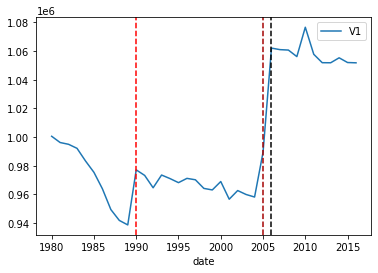

In [3]:
# Plot the true annotated labels
print(rail_lines_df.loc[rail_lines_df['is_CPD']==1])

figure(figsize=(12, 6), dpi=80);
rail_lines_df.plot('date', 'V1')

xposition = rail_lines_df.loc[rail_lines_df['is_CPD']==1][['t']].values

colormap = plt.cm.flag
colors = [colormap(i) for i in np.linspace(0, 1,len(xposition))]
for xc,color in zip(xposition,colors):
    plt.axvline(x=xc, color=color, linestyle='--');

#### Prepare data - Create time-series data from pandas dataframe

TimeSeriesData is the basic data structure in Kats to represente univariate and multivariate time series. One of the ways to initiate it is TimeSeriesData(df), where df is a pd.DataFrame object with a "time" column and any number of value columns. Here we construct TimeSeriesData objects for each time series.

Here we are dealing with a Univariate time series.

In [4]:
# Create TimeSeriesData object to input in KATS algorithms
df = rail_lines_df
df['time']= df['date']
tsd = TimeSeriesData(df.loc[:,['time','V1']])
tsd[:5]

time            V1
0 1980-01-01  1.000507e+06
1 1981-01-01  9.961533e+05
2 1982-01-01  9.949100e+05
3 1983-01-01  9.920928e+05
4 1984-01-01  9.833025e+05

#### CUSUMDetector parameters

The full set of parameters for the `detector` method in `CUSUMDetector`, all of which are optional and have default values, are as follows: 
* **threshold**: float, significance level, **default value = 0.01**;
* **max_iter**: int, maximum iteration in finding the changepoint, **default value = 10**;
* **delta_std_ratio**: float, the mean delta has to be larger than this parameter times std of the data to be considered as a change,**default value = 1**;
* **min_abs_change**: int, minimal absolute delta between mu0 and mu1, **default value = 0**
* **start_point**: int, the start idx of the changepoint, None means the middle of the time series, **default value = None**
* **change_directions**: list\[str], a list contain either or both 'increase' and 'decrease' to specify what type of change to be detected. If we do not specify which change directions we are looking for using the change_directions parameter, CUSUMDetector will look for both increases and decreases, **default value = None**. 
* **interest_window**: list\[int, int], a list containing the start and end of the interest window where we will look for a change point. Note that the llr will still be calculated using all data points,**default value = None**. CUSUMDetector can only return one change point in each direction, we can use the interest_window parameter narrow the search window in the case that the input time series contains multiple change points. However, the change point point we return must pass the likelihood ratio test for the entire time series in addition to passing the likelihood ratio test within the interest window 
* **magnitude_quantile**: float, the quantile for magnitude comparison, if none, will skip the magnitude comparison,**default value = None**;
* **magnitude_ratio**: float, comparable ratio,**default value = 1.3**;
* **magnitude_comparable_day**: float, maximal percentage of days can have comparable magnitude to be considered as regression,**default value = 0.5**;
* **return_all_changepoints**: bool, return all the changepoints found, even the insignificant ones,**default value = False**.

### Observations

-  CUSUMDetector can only return one change point in each direction. Out of the 3 true annotated change points, only the change point at year 2005 has been detected as it is significant i.e, it passed the likelihood ratio test for the entire time series in addition to passing the likelihood ratio test within the interest window(if provided as a parameter)

- We can use the interest_window parameter to narrow the search window in the case that the input time series contains multiple change points. However, it must pass the likelihood test for the entire time series as well as within the interest window. The other 2 points did not pass the LRT within the interest window, so these insignificant points weren't detected.

- Point 2005 is significant both at the Time Series and interest window level and detected with a very high confidence of 1.0 at the Time Series level
- Points 2006 and 1990 are insignificant at the interest window level though significant at the Time Series level with a very high confidence. 

#### Cusum detects only 1 point in any given direction

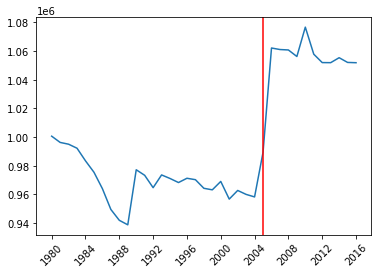

[(TimeSeriesChangePoint(start_time: 2005-01-01 00:00:00, end_time: 2005-01-01 00:00:00, confidence: 1.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f951055dca0>), (TimeSeriesChangePoint(start_time: 1981-01-01 00:00:00, end_time: 1981-01-01 00:00:00, confidence: 0.0), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9510623490>)]


In [5]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#The CUSUMDetector detected only point 2005 in increase  direction 
change_points = detector.detector(return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

#### Passing interest window parameter for detecting other points

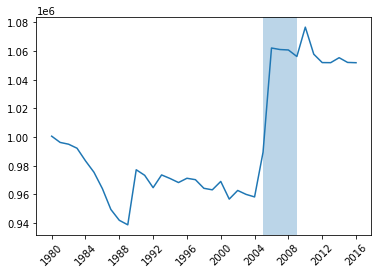

[(TimeSeriesChangePoint(start_time: 2006-01-01 00:00:00, end_time: 2006-01-01 00:00:00, confidence: 0.9999999999989728), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9510576b20>), (TimeSeriesChangePoint(start_time: 2008-01-01 00:00:00, end_time: 2008-01-01 00:00:00, confidence: 0.9999997590836197), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f95106ad220>)]


In [6]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

change_points = detector.detector(interest_window=[25,30],return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

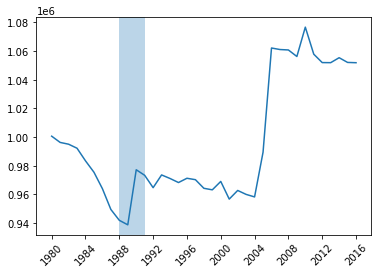

[(TimeSeriesChangePoint(start_time: 1989-01-01 00:00:00, end_time: 1989-01-01 00:00:00, confidence: 0.8736848775962036), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f95104aa430>), (TimeSeriesChangePoint(start_time: 1990-01-01 00:00:00, end_time: 1990-01-01 00:00:00, confidence: 0.9014021947771731), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9510613d00>)]


In [7]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#In the case below where there is only an increase, it will detect that increase.
change_points = detector.detector(interest_window=[8,12],return_all_changepoints=True)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

#### Generating interest windows and tuning the detector parameters

- **threshold** - The default value of this parameter is 0.01. Changing it to a high value say >= 0.5 and rerunning for the points that were not detected previously detects them now
- **interest_window** - You want to have this window with atleast 2 points before and after the change point, else change point won't be detected. For change point 10, a window of [8,12] works, but [9,12] doesn't.

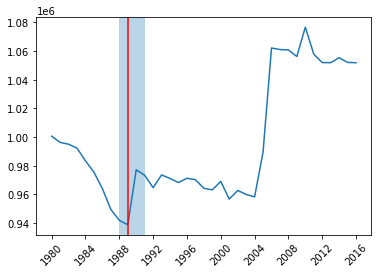

[(TimeSeriesChangePoint(start_time: 1989-01-01 00:00:00, end_time: 1989-01-01 00:00:00, confidence: 0.8736848775962036), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9506bf6760>), (TimeSeriesChangePoint(start_time: 1990-01-01 00:00:00, end_time: 1990-01-01 00:00:00, confidence: 0.9014021947771731), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9510a7ce80>)]


In [8]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

#In the case below where there is only an increase, it will detect that increase.
change_points = detector.detector(interest_window=[8,12],return_all_changepoints=True,threshold=0.5,delta_std_ratio=0.5)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

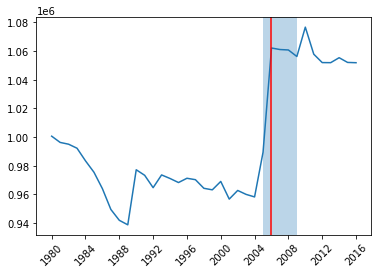

[(TimeSeriesChangePoint(start_time: 2006-01-01 00:00:00, end_time: 2006-01-01 00:00:00, confidence: 0.9999999999989728), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f95106ad460>), (TimeSeriesChangePoint(start_time: 2008-01-01 00:00:00, end_time: 2008-01-01 00:00:00, confidence: 0.9999997590836197), <kats.detectors.cusum_detection.CUSUMMetadata object at 0x7f9510a2d8e0>)]


In [9]:
#CUSUMDetector only supports univariate time series. For multivariate time series, we need to use MultiCUSUMDetector
detector = CUSUMDetector(tsd)

change_points = detector.detector(interest_window=[25,30],return_all_changepoints=True,threshold=0.9)

plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

print(change_points)

In [10]:
# Segment the time series by interest windows
cpts = [10,25, 26]
after = range(1,20,4)
before = range(1,20,4)
int_window = []
for cp in cpts:
    for windowa in after:
        for windowb in before:
            if (cp+windowa) > 0 and (cp-windowb) > 0:
                int_window.append([cp-windowb,cp+windowa])

In [11]:
# Tune hyperparameters: comparison_window and smoothing_window_size

# Parse list of changepoints and confidence
def parse_CPs(changepoints,df):    
    cp_list = []
    for cp in changepoints:
        changepoint1 = str(cp[0])[34:38]
        changepoint = df.loc[df['time'].isin([changepoint1]),'t'].values[0]
        confidence = str(cp[0])[98:105]
        regression_detected = cp[1].regression_detected
        if regression_detected:
            cp_list.append(str(changepoint)+":"+str(changepoint1))
            #cp_list.append("cp: "+str(changepoint)+" => conf:"+str(confidence)+" => sig: "+str(regression_detected))
    return cp_list

# Hyperparameter tuning for RSD algo
def hp_tuning_cusum(tsd,df):

    # Initialize the detector
    detector = CUSUMDetector(tsd)
    hp_list = []
    hp_value = {}
    for threshold in np.linspace(0,1,100):
        for interest_window in int_window:
            #for min_abs_change in np.linspace(0,1,25):
            change_points = detector.detector(
                threshold=threshold,
                interest_window=interest_window,
                return_all_changepoints=True
                #min_abs_change=min_abs_change
                )
            hp_value = {'threshold': threshold, 'interest_window':interest_window, 'CP': parse_CPs(change_points,df)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [12]:
# Run the hyperparameter tuning methods and export the results to a .csv file
dataset_hp_cusum = hp_tuning_cusum(tsd,df)
print(dataset_hp_cusum.head())
dataset_hp_cusum.to_csv("rail_lines_out.csv")

   threshold interest_window  CP
0        0.0         [9, 11]  []
1        0.0         [5, 11]  []
2        0.0         [1, 11]  []
3        0.0         [9, 15]  []
4        0.0         [5, 15]  []


#### Hyperparameter tuning of the threshold and interest_window

The true changepoints 2005, 2006 and 1990 are detected for the following parameters:
- cp '26:2006' is detected only when threshold is between 0.3 to 1.0 (inclusive) with window size having 1 point before and atleast 4 points after the cp. If the window size is too wide or too narrow, change point is not detected. Only window range [25,30] to [25, 43] detects this changepoint. 

- cp '25:2005' is detected for all thresholds from 0.01 to 1. Most of the interest windows detects this point by default without needing any hyper parameter tuning.

- cp '10:1990' is detected for threshold ranging between 0.7 to 1 (inclusive). Window that is successul in detecting the changepoint has 1 point before the cp and atleast 4 points after cp upto 13 points. For example, for a cp 10, window [9,14] to [9,23] is successful. 

**In order to choose the optimum threshold, we can choose 0.7 and above. Interest window should be 1 point before and atleast 4 points after cp upto 12 points after cp. **

In [13]:
# Create interest windows for plotting
windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['10:1990']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()

windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['26:2006']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()

windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['25:2005']])][['interest_window','threshold','CP']]
df1 = windows.groupby([windows['interest_window'].map(tuple),windows['CP'].map(tuple)]).agg({'threshold':['min','max']}).reset_index()

windows = dataset_hp_cusum.loc[dataset_hp_cusum.CP.isin([['26:2006'],['10:1990'],['25:2005']])][['interest_window','threshold','CP']]
df1 = windows.groupby(windows['CP'].map(tuple)).agg({'threshold':['min','max'],'interest_window':['min','max']}).reset_index()
print(df1.head())

           CP threshold      interest_window          
                    min  max             min       max
0  (10:1990,)  0.353535  1.0         [9, 15]   [9, 23]
1  (25:2005,)  0.010101  1.0         [1, 27]  [24, 42]
2  (26:2006,)  0.090909  1.0        [25, 31]  [25, 43]


In [14]:
# Plot the results of hyperparameter tuning
import hiplot as hip

cp_hiplot = hip.Experiment.from_csv('rail_lines_out.csv')
cp_hiplot.display()

<IPython.core.display.Javascript object>

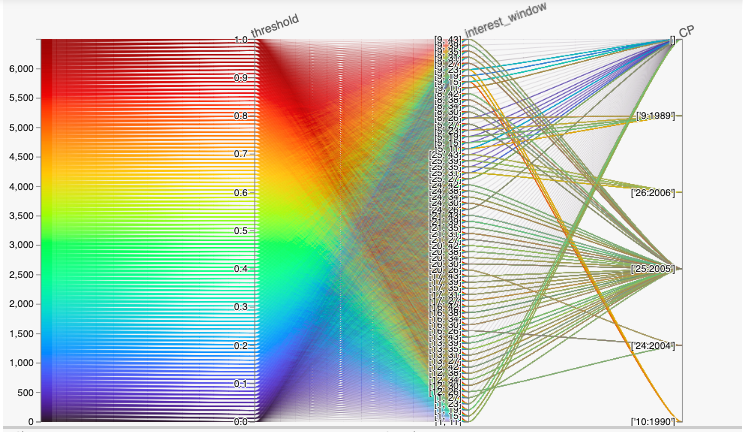

#### Hyperparameter tuning of delta_std_ratio and min_abs_change

In [15]:
# Hyperparameter tuning for cusum algo
def hp_tuning_cusum1(tsd,df):

    # Initialize the detector
    detector = CUSUMDetector(tsd)
    hp_list = []
    hp_value = {}
    n=len(tsd)
 
    for min_abs_change in np.linspace(0,1,10):
        for delta_std_ratio in np.linspace(0,1,10):
            change_points = detector.detector(
                threshold=0.7,
                interest_window=[9,15],
                return_all_changepoints=True,
                min_abs_change=min_abs_change,
                delta_std_ratio=delta_std_ratio
                )
            hp_value = {'delta_std_ratio':delta_std_ratio,'min_abs_change':min_abs_change, 'CP': parse_CPs(change_points,df)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [16]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_cusum1 = hp_tuning_cusum1(tsd,df)
dataset_hp_cusum1.to_csv("rail_lines_out1.csv")

Here irrespective of the values set for min_abs_change whose default value is 0 and  delta_std_ratio  whose default value is 1, the cp get detected only when threshold is over 0.6

In [17]:
cp_hiplot1 = hip.Experiment.from_csv('rail_lines_out1.csv')
cp_hiplot1.display()

<IPython.core.display.Javascript object>

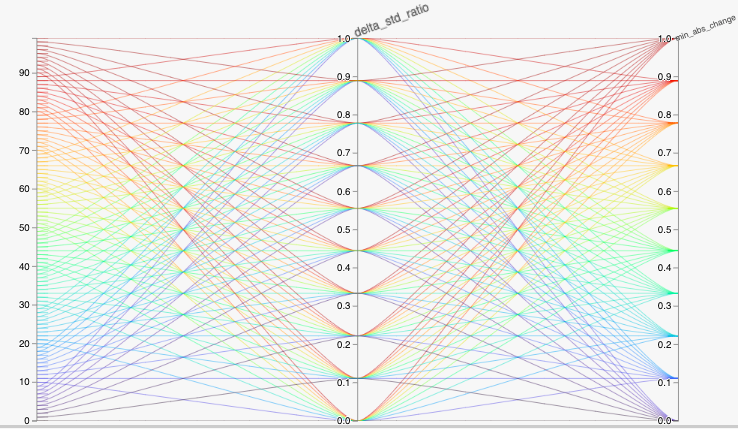

In [18]:
# Plot the time series with multiple changepoints
tsd_copy = tsd
multi_cp_ts=tsd_copy
historical_window = 1
scan_window = 5
step = 3
changepoints = []
n = len(multi_cp_ts)
for end_idx in range(historical_window + scan_window, n, step):
    start_idx = end_idx - (historical_window + scan_window) 
    #print(start_idx , end_idx,[historical_window, historical_window + scan_window])
    tsd = multi_cp_ts[start_idx : end_idx]
    changepoints += CUSUMDetector(tsd).detector(interest_window=[historical_window, historical_window + scan_window],threshold=0.5)

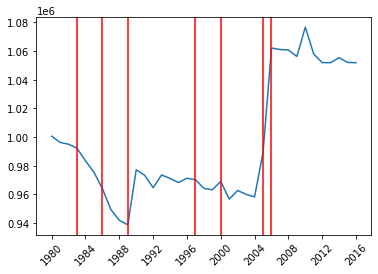

In [19]:
# plot the results
detector = CUSUMDetector(multi_cp_ts) # we are not really using this detector
detector.detector() # this call to detector is not being used for anything

plt.xticks(rotation=45)
detector.plot(changepoints)
plt.show()

#### Main takeaways

- Cusum detects only 1 change point in any direction. In order to detect all the changepoints, we need to specify interest window parameter for all the other change points. Based on hyper parameter tuning, the interest window has to be in the range of [changepoint-1, changepoint+(4 to 10 points)] for a changepoint.

- While the threshold parameter depends on the interest window range, a higher threshold of 0.7 and over should generally work for all interest windows. Please note that the default threshold value is 0.01.

- Hyperparameter tuning of start point, delta_std_ratio and min_abs_change wasn't very helpful.

- If the data has seasonal component to it, then using an interest window in a time series with seasonality will give us a false positive. This can be mitigated by comparing the magnitude of the time series in the interest window to the magnitude of the the time series prior to the interest window. This is done by using parameters magnitude_quantile, magnitude_comparable_day, and magnitude_ratio. Based on the parameters we are using, we will keep a changepoint detected in interest_window only if at least half of the intervals prior to interest_window with the same length as interest_window have a maximum value not exceeding p / magnitude_ratio. Include this changepoint if and only if this proportion of days exceeds magnitude_comparable_day.


### 1b. Evaluating RobustStatDetector <a name="part1b"></a>
The Robust Stat Detector detects shifts in mean in a time-series. It takes into account a fixed number of points, `comparison_window`, over which to calculate the mean, `smoothing_window_size`, and detects changepoints within a given confidence level, `p_value_cutoff`. 

The code below utilizes the [GDP of Japan dataset](https://github.com/alan-turing-institute/TCPD/tree/master/datasets/gdp_japan) from the Turing study to explore the Robust Stat Detector algorithm and its parameters. It also evaluates the performance of the algorithm on [Population of Centralia, PA](https://github.com/alan-turing-institute/TCPD/tree/master/datasets/centralia) and [Volume of the Nile River]() datasets from the same study. 

#### Import the data and plot true changepoint

In [1]:
# List the indices of the true changepoints in the GDP of Japan timeseries from the Turing study

import json 
import pandas as pd 
import numpy as np 
import itertools 

dataset = 'gdp_japan'
annotator_df = pd.read_json('TCPD-master/annotations.json') 
dataset_df = annotator_df[[dataset]] 
list2d = np.array(dataset_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
dataset_annotation_lst = list(itertools.chain.from_iterable(list2d))
dataset_annotation_lst

[32, 32]

True Changepoint at: 1992


<Figure size 960x480 with 0 Axes>

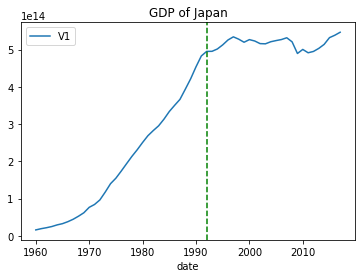

In [2]:
# Plot the timeseries and the true changepoint

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

path = str('TCPD-master/datasets/' + dataset + '/' + dataset + '.json')
ts = TimeSeries.from_json(path)
dataset_df = ts.df
dataset_df['date'] =ts.datestr
#print(dataset_df.dtypes)
column_name = 'V1'
figure(figsize=(12, 6), dpi=80)
dataset_df.plot('date', 'V1')
dataset_df['is_CPD'] = np.where(dataset_df.t.isin(dataset_annotation_lst), 1,0)
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[0], color='green', linestyle='--')
plt.title("GDP of Japan")
true_cp = dataset_df.iloc[32]['date']
print("True Changepoint at: " + true_cp )

#### Detect and plot changepoint found using RSD

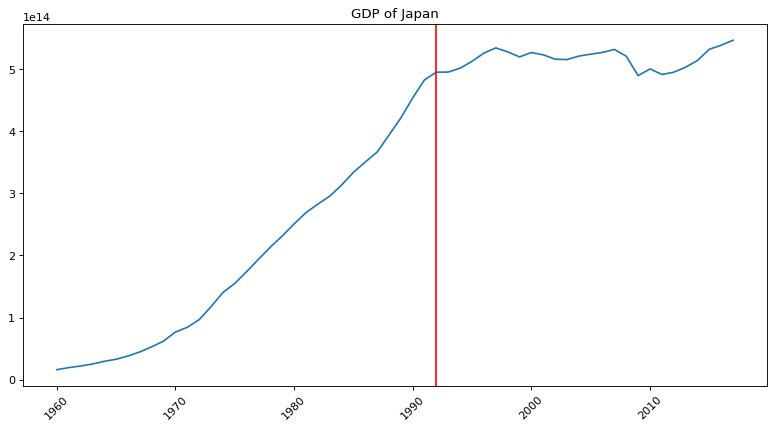

Detected changepoint(s): 


[(TimeSeriesChangePoint(start_time: 1992-01-01T00:00:00.000000000, end_time: 1992-01-01T00:00:00.000000000, confidence: 0.9581645425913177),
  <kats.detectors.robust_stat_detection.RobustStatMetadata at 0x7fabdad39e20>)]

In [3]:
# Detect changepoints in the GDP of Japan timeseries with at least 95% confidence with Robust Stat Detector algorithm

from kats.detectors.robust_stat_detection import RobustStatDetector
from kats.consts import TimeSeriesData

df = dataset_df
df['time']= pd.to_datetime(df['date'])
tsd = TimeSeriesData(df.loc[:,['time', column_name]])
detector = RobustStatDetector(tsd)
change_points = detector.detector(comparison_window=5, smoothing_window_size=5, p_value_cutoff=0.05)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
plt.title("GDP of Japan")
detector.plot(change_points)
print("Detected changepoint(s): ")
change_points

#### Hyperparameter tuning of comparison_window and smoothing_window_size

In [4]:
# Tune hyperparameters: comparison_window and smoothing_window_size

# Parse list of changepoints and confidence
def parse_CPs(changepoints):    
    cp_list = []
    for cp in changepoints:
        changepoint = str(cp[0])[34:38]
        confidence = str(cp[0])[119:125]
        cp_list.append(changepoint)
    return cp_list

# Hyperparameter tuning for RSD algo
def hp_tuning_RSD(tsd):

    # Initialize the detector
    detector = RobustStatDetector(tsd)

    hp_list = []
    #hp_result['true_CP_detected'] = []
    comparison_window = 0
    smoothing_window_size = 0
    p_value_cutoff = 0.05
    hp_value = {}
    for i in range(1,20):
        for j in range(1, 20):
            #for k in range(1, 10):
                #threshold = k*0.1
            smoothing_window_size = i
            comparison_window = j
            change_points = detector.detector(
                comparison_window=comparison_window,
                smoothing_window_size=smoothing_window_size,
                p_value_cutoff=0.05
            )
            hp_value = {'comparison_window': comparison_window, 'smoothing_window': smoothing_window_size, 'CP': parse_CPs(change_points)}
            hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [5]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_rsd = hp_tuning_RSD(tsd)
dataset_hp_rsd.to_csv("gdp_japan_hp_rsd.csv")

In [6]:
# Plot the results of hyperparameter tuning

import hiplot as hip

cp_hiplot = hip.Experiment.from_csv('gdp_japan_hp_rsd.csv')
cp_hiplot.display()

<IPython.core.display.Javascript object>

The true changepoint, '1992', is only detected when the `comparison_window` or `smoothing_size_window` ranges from 1-8 or is at the value of 19 in a dataset of 54 rows. Interestingly, the valid range for both parameters is the same and either one should be within the valid range to detect the true changepoint. 

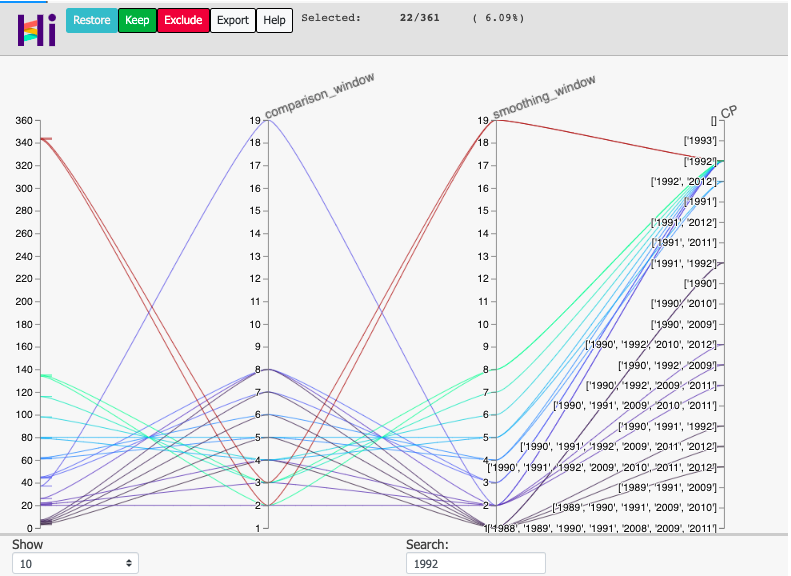

#### Varying dataset sizes
Upon repeating the same hyperparamter sweep for the Robust Stat Detector algorithm on various timeseries datasets with a different number of datapoints, we observed the following results. 

The dataset tracking the population of Centralia, PA has only 15 datapoints. Tuning hyperparameters to find the combinations with the true changepoint detected results in the Hiplot below. Here it is observed that when either the comparison_window or smoothing_window_size is: 1, 4-6, 8, or 10, is the only time the true changepoint of 1990 is detected by the algorithm. This observation is consistent with other datasets where both parameters have the same valid range. It can also be observed that number of false positives or incorrectly detected changepoints increase as the comparison_window size increases. 

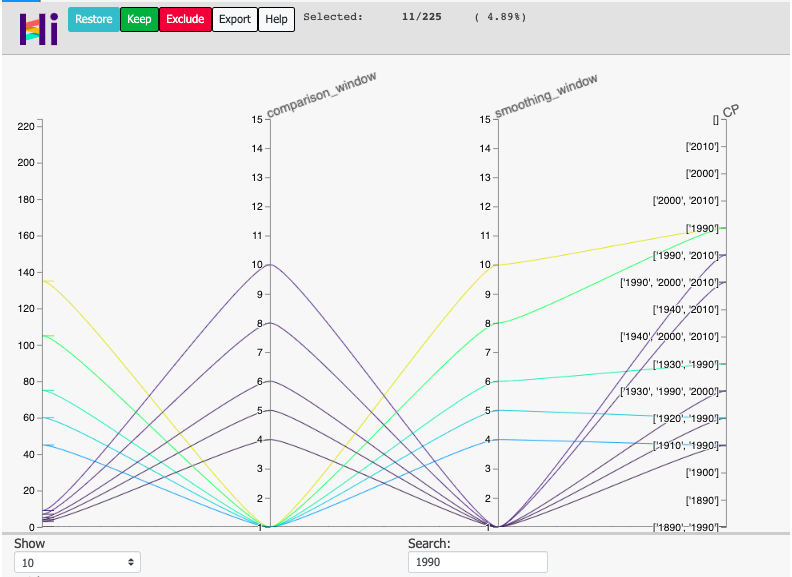

The timeseries capturing the volume of the Nile River across 100 years has a true changepoint during the year of 1899. This true changepoint is observed when the comparison_window or smoothing_window_size is between the 1-27 range. Additionally, we added another result column with the number of changepoints detected to observe the effect of parameters on the number of false positives detected. As seen in the Hiplot for the volume of the Nile River below, it is observed that having a smaller comparison_window than smoothing_window_size results in fewer false positive changepoints detected by the Robust Stat Detector algorithm. 

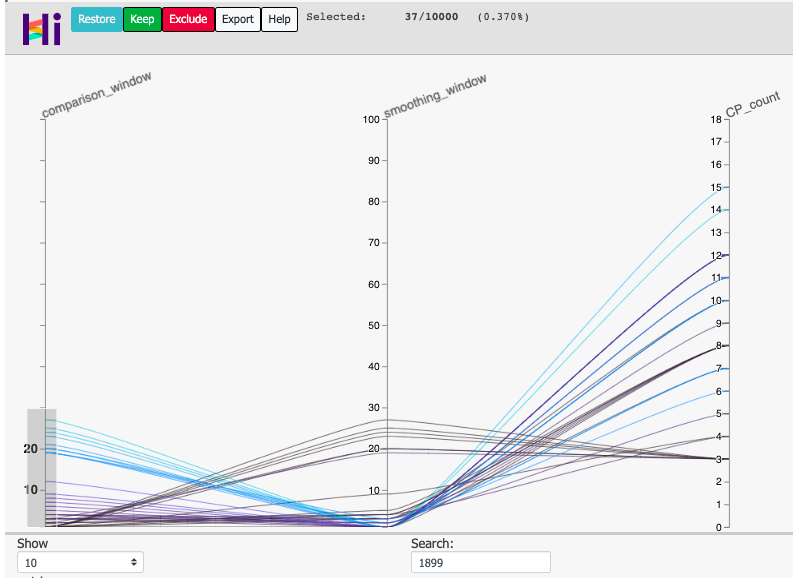

#### Main Takeaways

1. The valid range of values which detect true changepoints is the same for both comparison_window and smoothing_window_size.
2. Either but not necesarily both parameters need to be in the valid range to detect the true changepoint.
3. The valid range is usually <25% of the total rows or datapoints in a larger timeseries (more datapoints).
4. Having a smaller comparison_window than smoothing_window_size results in fewer false positives detected by the RSD algorithm. 

### 1c. Evaluating BOCPDetector <a name="part1c"></a>

Bayesian Online Change Point Detection (BOCPD) is a method for detecting sudden changes in a time series that persist over time. The BOCPD supports two types of models: Online model and Bayesian model.  The online model does not need to know the entire time series apriori. It only looks few steps ahead to make predictions. The Bayesian model is offline model and supports specifying prior beliefs in the model as with any other bayesian models. The online model has three `model` types, each of which are assessed in this analysis. 

* NORMAL_KNOWN_MODEL: Normal model with variance known. Use this to find level shifts in normally distributed data.
* TREND_CHANGE_MODEL : This model assumes each segment is generated from ordinary linear regression. Use this model to understand changes in slope, or trend in time series.
* POISSON_PROCESS_MODEL: This assumes a Poisson generative model. Use this for count data, where most of the values are close to zero.

This analysis of BOCPD uses the [Total Private Construction Spending](https://github.com/alan-turing-institute/TCPD/tree/master/datasets/construction) dataset from the Turing study starting with the Normal_Known_Model. 

#### List and plot the true changepoints

In [12]:
# List the indices of the true changepoints in the "Total Private Construction Spending" from the Turing study

import json 
import pandas as pd 
import numpy as np 
import itertools 
import warnings
warnings.filterwarnings("ignore")

dataset = 'construction'
annotator_df = pd.read_json('TCPD-master/annotations.json') 
dataset_df = annotator_df[[dataset]] 
list2d = np.array(dataset_df).flatten() 
list2d = [l for l in list2d if (type(l)==list)] 
dataset_annotation_lst = list(itertools.chain.from_iterable(list2d))
dataset_annotation_lst

[193, 217, 192, 193, 136, 205]

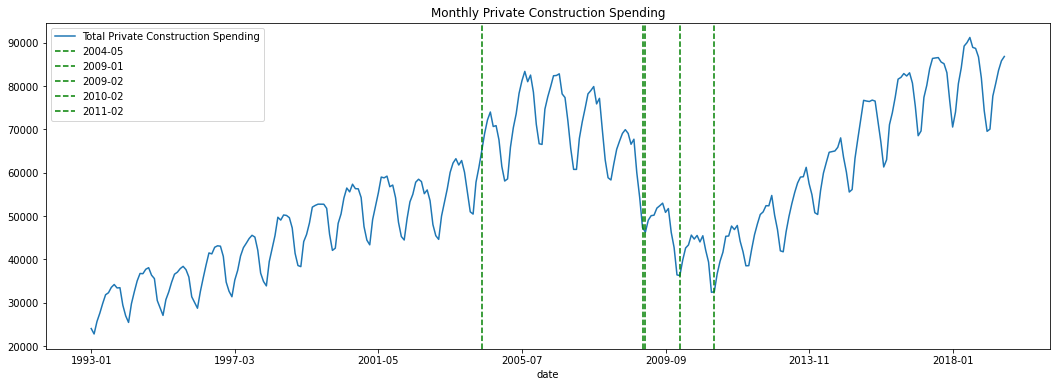

In [8]:
# Plot the timeseries and the true changepoint

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure 
from load_dataset import TimeSeries 

path = str('TCPD-master/datasets/' + dataset + '/' + dataset + '.json')
ts = TimeSeries.from_json(path)
dataset_df = ts.df
dataset_df['date'] =ts.datestr
#print(dataset_df.dtypes)
column_name = 'Total Private Construction Spending'
dataset_df.plot('date', column_name,figsize=(18, 6))
dataset_df['is_CPD'] = np.where(dataset_df.t.isin(dataset_annotation_lst), 1,0)
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[0], color='green', linestyle='--', label='2004-05')
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[1], color='green', linestyle='--', label='2009-01')
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[2], color='green', linestyle='--', label='2009-02')
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[3], color='green', linestyle='--', label='2010-02')
plt.axvline(dataset_df.loc[dataset_df['is_CPD']==1][['t']].values[4], color='green', linestyle='--', label='2011-02')
plt.legend()
plt.title("Monthly Private Construction Spending")
true_cp = dataset_df.iloc[32]['date']

#### Detect and plot the changepoints using BOCPD NORMAL_KNOWN_MODEL

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "known_prec_multiplier". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "cp_prior". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.



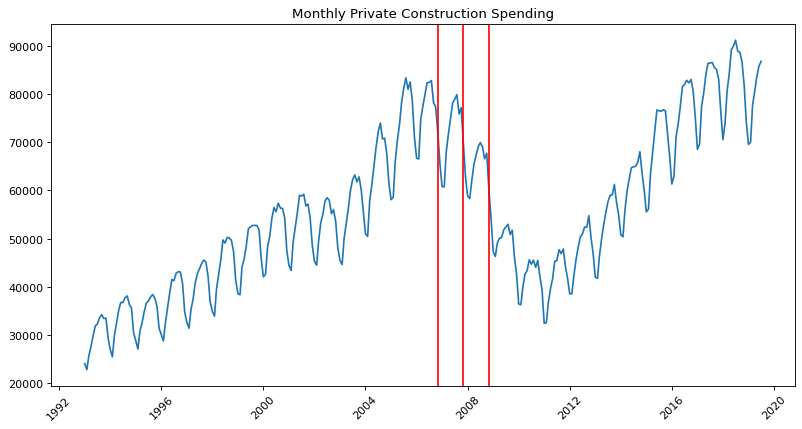

Detected changepoint(s): 


[(TimeSeriesChangePoint(start_time: 2006-11-01T00:00:00.000000000, end_time: 2006-11-01T00:00:00.000000000, confidence: 0.5643137326336457),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7fabd08e70a0>),
 (TimeSeriesChangePoint(start_time: 2007-11-01T00:00:00.000000000, end_time: 2007-11-01T00:00:00.000000000, confidence: 0.6217542998560829),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7fabdad85a30>),
 (TimeSeriesChangePoint(start_time: 2008-11-01T00:00:00.000000000, end_time: 2008-11-01T00:00:00.000000000, confidence: 0.6349703667802497),
  <kats.detectors.bocpd.BOCPDMetadata at 0x7fabd35aa850>)]

In [9]:
## Detect changepoints in the Private Construction Spending timeseries with BOCP Detector algorithm

from kats.detectors.bocpd import BOCPDetector, BOCPDModelType, NormalKnownParameters, TrendChangeParameters, PoissonModelParameters
from kats.consts import TimeSeriesData

df = dataset_df
df['time']= pd.to_datetime(df['date'])
tsd = TimeSeriesData(df.loc[:,['time', column_name]])
detector = BOCPDetector(tsd)

#parameters for normal probability model
model_dist_paramters = NormalKnownParameters()
model_dist_paramters.empirical=True
model_dist_paramters.known_prec_multiplier=[1.0, 2.0, 3.0, 4.0, 5.0]

change_points = detector.detector(
    model=BOCPDModelType.NORMAL_KNOWN_MODEL,
    model_parameters=model_dist_paramters,    
    #changepoint_prior=.1#prior belief    
    #threshold=.5    
)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
plt.title("Monthly Private Construction Spending")
detector.plot(change_points)
print("Detected changepoint(s): ")
change_points

#### Test other BOCPD ModelTypes

#### <font color='red'>TREND_CHANGE_MODEL has error (don't run as it is)</font>

In [ ]:
# Use the TREND_CHANGE_MODEL
detector = BOCPDetector(tsd)

#parameters for normal probability model
model_dist_paramters = TrendChangeParameters()
model_dist_paramters.empirical=True
#model_dist_paramters.known_prec_multiplier=[1.0, 2.0, 3.0, 4.0, 5.0]

change_points = detector.detector(
    model=BOCPDModelType.TREND_CHANGE_MODEL,
    #model_parameters=model_dist_paramters,    
    #changepoint_prior=.1,#prior belief    
    #threshold=.5,
    #lag=10
)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
plt.title("Monthly Private Construction Spending")
detector.plot(change_points)
print("Detected changepoint(s): ")
change_points

#### <font color='red'>POISSON_PROCESS_MODEL has error  (exhaust rejection sampling threshold)</font>

In [ ]:
# Use the POISSON_PROCESS_MODEL
detector = BOCPDetector(tsd)

#parameters for normal probability model
model_dist_paramters = PoissonModelParameters()
model_dist_paramters.empirical=True


change_points = detector.detector(
    model=BOCPDModelType.POISSON_PROCESS_MODEL,
    #model_parameters=model_dist_paramters,    
    lag=10 
)
figure(figsize=(12, 6), dpi=80)
plt.xticks(rotation=45)
plt.title("Monthly Private Construction Spending")
detector.plot(change_points)
print("Detected changepoint(s): ")
change_points

#### Hyperparameter tuning of lag, changepoint_prior, and known_prec_multiplier

In [10]:
# Tune hyperparameters: lag, changepoint_prior, and known_prec_multiplier

# Parse list of changepoints and confidence
def parse_CPs(changepoints):    
    cp_list = []
    for cp in changepoints:
        changepoint = str(cp[0])[34:44]
        confidence = str(cp[0])[119:125]
        cp_list.append(changepoint)
    return cp_list

# Hyperparameter tuning for BOCP algo
def hp_tuning_BOCP(df):

    # Initialize the detector
    detector = BOCPDetector(tsd)    
    hp_list = []
    #hp_result['true_CP_detected'] = []
    lag = 0
    changepoint_prior = .1
    threshold = 0.05
    hp_value = {}
    for i in range(1,20):
        for j in np.arange(0.0, 1.0, 0.1):
            for k in range(1, 10):                
                model_dist_paramters = NormalKnownParameters()
                model_dist_paramters.empirical=True
                model_dist_paramters.known_prec_multiplier=[k]                
                lag = i
                changepoint_prior = j
                change_points = detector.detector(
                    model=BOCPDModelType.NORMAL_KNOWN_MODEL,
                    model_parameters=model_dist_paramters,
                    lag=lag,
                    changepoint_prior=changepoint_prior,
                    threshold=0.05
                )
                hp_value = {'lag': lag, 'changepoint_prior': changepoint_prior,'known_prec_multiplier': model_dist_paramters.known_prec_multiplier, 'CP': parse_CPs(change_points)}
                hp_list.append(hp_value)
    return pd.DataFrame(hp_list)

In [13]:
# Run the hyperparameter tuning methods and export the results to a .csv file

dataset_hp_bocp = hp_tuning_BOCP(tsd)
dataset_hp_bocp.to_csv("Private_Construction_Spending.csv")

KeyboardInterrupt: 

In [ ]:
# Plot the results of hyperparameter tuning

import hiplot as hip

cp_hiplot = hip.Experiment.from_csv('Private_Construction_Spending.csv')
cp_hiplot.display()

The exact true changepoints are not detected by algorithms. All the three hyper parameters does not have any impact on the identified changepoints: `lag`, `changepoint_prior` and `known_prec_multiplier`.

Upon repeating the same hyperparamter sweep for the BOCP Detector algorithm on various timeseries datasets with a different number of datapoints, we observed the following takeaways. 

#### Main Takeaways
1. None of the three hyperparameter have impact on changepoint detected. 
2. The confidence interval is highly dependent on data size. The higher the data size, higher the confidence in changepoint detected.  
3. Out of the three underlying probability distribution model, Normal model detects either the exact changepoints or near changepoint. The Poisson model does not detect much changepoints and exhaust the sampling threshold without detecting.

## Part 2: Applied Research on Google Mobility Data <a name="part2"></a>

With the observations found from the sections prior, we can now apply the KATS algorithms to a larger dataset with over 20,000 rows. We start by exploring the Google Mobility dataset 2020 for the United States which can be downloaded from [here](https://www.google.com/covid19/mobility/).

The data shows how visits to places, such as grocery stores and parks, are changing in each geographic region compared to a baseline. The baseline is the median value, for the corresponding day of the week, during the five week period Jan 3–Feb 6, 2020. For each region-category, the baseline isn’t a single value. It is seven individual values. The same number of visitors on two different days of the week result in different percentage changes.
Larger changes do not mean more visitors and smaller changes do not mean less visitors. Day to day comparison of changes will lead to misleading results. 
Mobility trends are measured across six broad categories:
* Residential: places of residence.
* Grocery & Pharmacy stores: places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.
* Workplaces: places of work.
* Parks: places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.
* Transit stations: places like public transport hubs such as subway, bus, and train stations.
* Retail & Recreation: places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

The 'Residential' category shows a change in duration, while the other categories measure a change in total visitors.
The dataset has 812065 observations and 15 features. The data is completely anonymized from users who have turned on the Location History setting, which is off by default. If there’s not enough data for an estimate of change from the baseline, that means Google wasn’t able to confidently and anonymously compute the estimate.

### Methodology

In this section, we apply each changepoint detection algorithm to the Google Mobility dataset to validate our conclusions from the previous sections as well as validate how well the algorithms perform on a real-world scenario in which there are no concrete, labelled changepoints. 

### 2a. Application of CUSUMDetector <a name="part2a"></a>


### 2b. Application of BOCPDetector <a name="part2b"></a>

### 2c. Application of RSDetector <a name="part2c"></a>

## Part 3: The Covid-19 Story <a name="part3"></a>

### 3a. Covid-19 in the United States <a name="part3a"></a>

### 3b. Covid-19 in Washington State <a name="part3b"></a>

### 3c. Covid-19 in King County <a name="part3c"></a>

## Conclusion <a name="conclusion"></a>
### Recommendations
### Further Study